In [1]:
#This Cell Defines the parameters
import time
import cPickle as pickle
#import cv2
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from scipy.integrate import RK45
from scipy.integrate import quad
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.linear_model import LinearRegression

#Parameters
eta = 1.0					#Dispersion Parameter
n = 8						#Number of x-components
x_0 = np.zeros(n)			#Initial x
#x_0[0] = 0.99 
v_0 = x_0 					#v = x * (Integrating Factor). In this case IF = exp(eta*t), so IF(0) = 1 
sigma = 0.5					#SD of noise
S = np.zeros((n,n))			#covariance matrix for the noise
for i in xrange(5):
	S[i][i] = sigma 
h = 0.005					#Time step
bin_edges_quad = np.arange(0., 2.005, 0.005)
n_bins_quad = len(bin_edges_quad) - 1
bin_diff_quad = 0.005

In [137]:
#This Cell contains Definitions of the main functions

#The functions used in evaluating the IF Runge-Kutta step
#def f_IFRK(y, t): 
#	d = np.zeros(n)
#	d[0] = np.exp(-1.0 * eta * t) * (y[1] - y[n-2]) * y[n-1] #Note that the integrating factor's presence in e^(eta*t)N(e^-eta*t*v) has been simplified, and the linear part eliminated
#	d[1] = np.exp(-1.0 * eta * t) * (y[2] - y[n-1]) * y[0]
#	d[n-1] = np.exp(-1.0 * eta * t) * (y[0] - y[n-3]) * y[n-2]
#	for i in range(2, n-1):
#		d[i] = np.exp(-1.0 * eta * t) * (y[i+1] - y[i-2]) * y[i-1]
#	return d

#Alternate f - for a double well
#First version: double well in one coordinate
def f_IFRK(y, t):
    d = np.zeros(n)
    d[0] = (y[1] - y[n-2]) * y[n-1] + 4 * y[0] - 16 * (y[0]*y[0]*y[0]) #RK4 function for a double well in 2 coordinates
    d[1] = (y[2] - y[n-1]) * y[0] - y[1]
    d[n-1] = (y[0] - y[n-3]) * y[n-2] - y[n-1]
    for i in range(2, n-1):
        d[i] = (y[i+1] - y[i-2]) * y[i-1] - y[i]
    d[4] = (y[5] - y[2]) * y[3] + 4 * y[4] - 16 * (y[4]*y[4]*y[4])
    return d

def g_IFRK(y, t): 
	noise = np.zeros(n)
	for i in xrange(n):
		noise[i] = S[i][i] 
	return noise


#The function that moves a stochastic system dX = fdt + gdW ahead by time h via Runge-Kutta
def RK_SDE_Step(y, t, f, g, h): 
	m = len(y)
	dW = np.random.normal(0.0, np.sqrt(h), m)
	b = np.random.binomial(1, 0.5)	#The binary RV used in the improved Euler RK method for sde's
	if b == 0:
		b = -1
	K_1 = h * f(y, t) + (dW - np.sqrt(h) * b) * g(y, t) 
	K_2 = h * f(y + K_1, t + h) + (dW + np.sqrt(h)*b) * g(y + K_1, t + h)
	y_new = y + 0.5 * (K_1 + K_2) 
	return y_new

#The Function that evolves the deterministic part of an SDE only by time h using RK4
def RK_4_Step(y, t, f, h):
	K_1 = h * f(y, t)
	K_2 = h * f(y + 0.5 * K_1, t + 0.5 * h)
	K_3 = h * f(y + 0.5 * K_2, t + 0.5 * h)
	K_4 = h * f(y + K_3, t + h)
	y_new = y + (1.0 / 6.0) * (K_1 + 2. * K_2 + 2. * K_3 + K_4)
	return y_new

#The test function to be used in the stratified algorithm
def phi(x):
	return np.sum(x[0]**2)


#This function uses the ones above to generate the data (x, t) of the system evolving in time for a given step size
def RK_SDE_Sim(y_0, nsteps, f, g, h):
	x = np.zeros((nsteps,n))
	x[0] = x_0
	v = x_0
	for i in  xrange(nsteps-1): 
		v = x[i]
		v = RK_SDE_Step(v, 0., f, g, h)
		x[i + 1] = np.exp(-1.0 * eta * h) * v 
	t_range = np.arange(0.0, t_final, h)
	return x, t_range

#This function evolves x and t similarly, but by using RK4 on the deterministic part of v, converting back to x, then adding the appropriate noise
def RK_4_Sim(x_0, nsteps, f, S, h, phi, G):
	n = len(x_0)
	mu_estimate = 0.0
	x = np.zeros((nsteps,n))
	x[0] = x_0
	v = x_0
	nu_points = []
	for j in xrange(J):
		nu_points.append([])
	for i in  xrange(nsteps-1): 
		v = x[i]
		k = idx(x[i], strata)
		v = RK_4_Step(v, 0., f_IFRK, h)
		noise = np.zeros(n)
		for k in xrange(n):
			noise[k] = S[k][k] * np.sqrt(h) * np.random.normal(0., 1.)
		x[i + 1] = v + noise
		l = idx(x[i+1], strata)
		if k != l:
			G[k][l] += 1 
			nu_points[l].append(x[i+1])
		mu_estimate += phi(x[i+1]) / nsteps
	t_range = np.arange(0.0, t_final, h)
	return x, t_range, mu_estimate, G, nu_points


################################

#Index function returning the current stratum
#Index function returning the current stratum
def idx(y, strata):
    K = len(strata[0]) + 1
    for i in xrange(len(strata[0]) - 1):
        if (strata[0][i] <= y[0] < strata[0][i+1]):
            for k in xrange(len(strata[1]) - 1):
                if (strata[1][k] <= y[4] < strata[1][k+1]):
                    return (i + 1) * K + (k + 1)
            if y[4] >= strata[1][len(strata[1])-1]:
                return (i+1) * K + len(strata[1])
            if y[4] <= strata[1][0]:
                return (i+1)*K
        
    if y[0] < strata[0][0]:
        for k in xrange(len(strata[1]) - 1):
            if (strata[1][k] <= y[4] < strata[1][k+1]):
                return k+1
        if y[4] >= strata[1][len(strata[1])-1]:
            return len(strata[1])
        if y[4] <= strata[1][0]:
            return 0
            
    if y[0] >= strata[0][len(strata[0])-1]:
        for k in xrange(len(strata[1]) - 1):
            if (strata[1][k] <= y[4] < strata[1][k+1]):
                return (K-1) * K + (k + 1)
        if y[4] >= strata[1][len(strata[1])-1]:
            return (K-1) * K + len(strata[1])
        if y[4] <= strata[1][0]:
            return (K-1) * K

###########
#Note: For now, the algorithm will just pick from nu_j with equal probability for all points, and will average the trajectories for each iteration for the final answer

#Draw a sample from the current j-th injection measure
def injection_draw(points, probs):
	num_choices = len(points)
	probs_sum = np.sum(np.array(probs))
	probs_normalized = probs
	for i in xrange(len(probs)):
		probs[i] = probs[i] / probs_sum
	index_chosen = np.random.choice(num_choices, p=probs_normalized)
	return points[index_chosen]

#Run from a starting measure until exiting, return the exit point and the trajectory the particle took

#Note: Currently the lines evaluating H_phi in this function are commented out, since i'm only using
#The eig version atm and it does those calculations already. 
def RK_4_Sim_Exit(strata, nu_points, nu_probs, nu_weights, f, S, h):
	H = np.zeros((n, n_bins_phi))
	J = (len(strata[0]) + 1)**2
	exit_points = []
	trajectory = []
	for j in xrange(J):
		trajectory.append([])
	exit_times = np.zeros(J)
	for j in xrange(J):
		prob_sum = np.sum(nu_probs[j])
		if prob_sum <= 1.e-8 :
			nu_points[j] = nu_0_points[j]
			nu_probs[j] = np.ones(len(nu_0_points[j]))
		start_point = injection_draw(nu_points[j], nu_probs[j])
		idx_0 = idx(start_point, strata)
		current_idx = idx_0
		x_current = start_point
		while (current_idx == idx_0):
			trajectory[j].append(x_current)
#			test_fcn_vals = test_function_values(coef_1, coef_2, coef_3, x_current)
#			for s in xrange(n_polys):
#				test_value = test_fcn_vals[s]
#				test_weight = nu_weights[j]
#				H[s] = H[s] + np.histogram([test_value], bins=bin_edges_phi, weights=[test_weight])[0]
			#compute the next step
			v = x_current
			v = RK_4_Step(v, 0., f_IFRK, h)
			noise = np.zeros(len(v))
			for k in xrange(len(v)):
				noise[k] = S[k][k] * np.sqrt(h) * np.random.normal(0., 1.)
			x_current = v + noise
			#Update the index so the next loop checks if an exit has occurred
			current_idx = idx(x_current, strata)
			exit_times[j] += 1
		exit_points.append(x_current)
    
	return exit_points, trajectory, exit_times, H


#Note: For now at least, the iteration will just run for n_exits excursions in each stratum, so that the number of exit points is controlled. This can be changed later
def RK_4_stratified_iteration(n_exits, strata, nu_points, nu_probs, nu_weights, f, S, h, is_hist):
	J = (len(strata[0]) + 1)**2
	H_phi = np.zeros((n_polys, n_bins_phi))
	nu_points_next = []
	nu_probs_next = []
	time_spent = np.zeros(J)
	occupation = []
	for j in xrange(J):
		nu_points_next.append([])
		nu_probs_next.append([])
	nu_weights_next = np.zeros(J)
	test_fcn_sum = np.zeros((J, 3))
	if is_hist == True:
		iteration_hist = [[],[],[]]
		iteration_hist[0] = np.histogram([], bins=bin_edges, weights=np.ones(len([])))
		iteration_hist[1] = np.histogram([], bins=bin_edges, weights=np.ones(len([])))
		iteration_hist[2] = np.histogram([], bins=bin_edges, weights=np.ones(len([])))
		H = [[],[],[]]
		for i in xrange(3):
			H[i] = iteration_hist[i][0]
	G = np.zeros((J,J))
	for i in xrange(n_exits):
		exit_points, trajectory, exit_times, H_exit = RK_4_Sim_Exit(strata, nu_points, nu_probs, nu_weights, f, S, h)
		occupation.append(trajectory)
		for j in xrange(J):
			exit_idx = idx(exit_points[j], strata)
			nu_points_next[exit_idx].append(exit_points[j])
			nu_probs_next[exit_idx].append(nu_weights[j])
			G[j][exit_idx] += 1.
			time_spent += exit_times
		for j in xrange(3):
			for k in xrange(int(exit_times[j])):
				test_fcn_sum[j] += test_function_values(coef_1, coef_2, coef_3, trajectory[j][k])
		H_phi = H_phi + H_exit
                
	#If nu_points_next is empty for some j, set it equal to the last nu for that j
	for j in xrange(J):
		if (len(nu_points_next[j]) == 0):
			nu_points_next[j] = nu_points[j]
			nu_probs_next[j] = nu_probs[j]
            
            
	#Normalize G and compute the weights
	for i in xrange(J):
		row_sum = np.sum(G[i])
		for j in xrange(J):
			G[i][j] = G[i][j] / row_sum
			nu_weights_next[j] += G[i][j] * nu_weights[i]
	nu_weights_next = nu_weights_next / (np.sum(nu_weights_next))
    #Average old and new weights
	nu_weights_next = alpha * nu_weights_next + (1. - alpha) * nu_weights
    
    
	if is_hist == True:    
    #Form the histogram of the occupation measure with the newly calculated weights
		for k in xrange(n_exits):
			for j in xrange(J):
				for i in xrange(len(occupation[k][j])):
					x_point = occupation[k][j][i]
					H[0] = H[0] + np.histogram([x_point[0]], bins=bin_edges, weights = [nu_weights[j]])[0]
					H[1] = H[1] + np.histogram([x_point[4]], bins=bin_edges, weights = [nu_weights[j]])[0]
					H[2] = H[2] + np.histogram([x_point[19]], bins=bin_edges, weights = [nu_weights[j]])[0]
		iteration_hist = (H, bin_edges)

	if is_hist == True:
		return nu_points_next, nu_probs_next, nu_weights_next, test_fcn_sum, time_spent, iteration_hist
	if is_hist == False:
		return nu_points_next, nu_probs_next, nu_weights_next, test_fcn_sum, time_spent, H_phi

#New function - eigenvector version
def RK_4_stratified_iteration_eig(n_exits, strata, nu_points, nu_probs, nu_weights, f, S, h, is_hist):
	nu_points_next = []
	nu_probs_next = []
	xi_points = []
	H_quad = np.zeros((n, n_bins_quad))
	occupation = []    #The list of points in each excursion, for forming the occupation measure
	for j in xrange(J):
		nu_points_next.append([])
		nu_probs_next.append([])
		xi_points.append([])
	time_spent = np.zeros(J)
	nu_weights_next = np.zeros(J)
	test_fcn_sum = np.zeros((J,3))
	if is_hist == True:
		iteration_hist = [[],[],[]]
		iteration_hist[0] = np.histogram([], bins=bin_edges, weights=np.ones(len([])))
		iteration_hist[1] = np.histogram([], bins=bin_edges, weights=np.ones(len([])))
		iteration_hist[2] = np.histogram([], bins=bin_edges, weights=np.ones(len([])))
		H = [[],[],[]]
		for i in xrange(3):
			H[i] = iteration_hist[i][0]
	G = np.zeros((J,J))
	for i in xrange(n_exits):
		exit_points, trajectory, exit_times, H_exit = RK_4_Sim_Exit(strata, nu_points, nu_probs, nu_weights, f, S, h)
		for j in xrange(J):
			exit_idx = idx(exit_points[j], strata)
			xi_points[j].append([exit_points[j], exit_idx])
			G[j][exit_idx] += 1.
			time_spent += exit_times
		occupation.append(trajectory)
	#If nu_points_next is empty for some j, replace it with a single point
	#Normalize G and compute the weights
	for i in xrange(J):
		row_sum = np.sum(G[i])
		for j in xrange(J):
			G[i][j] = G[i][j] / row_sum
			nu_weights_next[j] += G[i][j] * nu_weights[i]
    
    #Compute the weights for the eigenvector version
#	evals, evecs = np.linalg.eig(G.T)
#	evec1 = evecs[:,np.isclose(evals, 1)]
#	evec1 = evec1[:,0]
#	nu_weights_next = evec1 / evec1.sum()
    
    #Option - Just use a high power of G instead of the eig function
	for k in xrange(100*J):
		nu_weights_next = np.dot(nu_weights, G)
	nu_weights_next = nu_weights_next / np.sum(nu_weights_next)
	nu_weights_next = alpha * nu_weights_next + (1. - alpha) * nu_weights
    
    #Form the histogram of the occupation measure with the newly calculated weights
	for k in xrange(n_exits):
		for j in xrange(J):
			n_points = len(occupation[k][j])
			for i in xrange(n_points):
				x_point = occupation[k][j][i]
				test_fcn_sum[j] += test_function_values(coef_1, coef_2, coef_3, x_point)

    #Build the new injection measures from xi and nu_weights_next
	for j in xrange(J):
		for i in xrange(n_exits):
			exit_point = xi_points[j][i][0]
			exit_idx = xi_points[j][i][1]
			nu_points_next[exit_idx].append(exit_point)
			nu_probs_next[exit_idx].append(nu_weights_next[j])
            
	#If nu_points_next is empty for some j, set it equal to the last nu for that j
	for j in xrange(J):
		if (len(nu_points_next[j]) == 0):
			nu_points_next[j] = nu_points[j]
			nu_probs_next[j] = nu_probs[j]
            
	if is_hist == True:    
        #Form the histogram of the occupation measure with the newly calculated weights
		for k in xrange(n_exits):
			for j in xrange(J):
				for i in xrange(len(occupation[k][j])):
					x_point = occupation[k][j][i]
					H[0] = H[0] + np.histogram([x_point[0]], bins=bin_edges, weights = [nu_weights_next[j]])[0]
					H[1] = H[1] + np.histogram([x_point[4]], bins=bin_edges, weights = [nu_weights_next[j]])[0]
					H[2] = H[2] + np.histogram([x_point[19]], bins=bin_edges, weights = [nu_weights_next[j]])[0]
		iteration_hist = (H, bin_edges)
    
	for k in xrange(n_exits):
		for j in xrange(J):
			for i in xrange(len(occupation[k][j])):
				x_point = occupation[k][j][i]
				for s in xrange(n):
					test_value = x_point[s]**2
					test_weight = nu_weights_next[j]
					H_quad[s] = H_quad[s] + np.histogram([test_value], bins=bin_edges_quad, weights=[test_weight])[0]
                

	if is_hist == True:
		return nu_points_next, nu_probs_next, nu_weights_next, test_fcn_sum, time_spent, iteration_hist, H_quad
	if is_hist == False:
		return nu_points_next, nu_probs_next, nu_weights_next, test_fcn_sum, time_spent, H_quad

def RK_4_Stratified(n_iterations, n_exits, strata, nu_points, nu_probs, nu_weights, f, S, h, l):
	nu_points_next, nu_probs_next, nu_weights_next, iteration_hist = RK_4_stratified_iteration(n_exits, strata, nu_points, nu_probs, nu_weights, f_IFRK, S, h)
	H = iteration_hist[0]
	for i in xrange(n_iterations-1):
		nu_points_next, nu_probs_next, nu_weights_next, iteration_hist = RK_4_stratified_iteration(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f, S, h)
		#H = (1. - l) * H + l * iteration_hist[0]
		H += iteration_hist[0]		#Option: Simply average the histogram of all iterations with equal weight, not using lambda (l)
	#Finally, Normalize H so it is a density
	H_sum = 1. * np.sum(H)
	for i in xrange(len(H)):
		H[i] = H[i] / H_sum
	stratified_hist = (H, bin_edges)
	return nu_points_next, nu_probs_next, nu_weights_next, stratified_hist

def TV_dist(hist_1, hist_2):
    l = len(hist_1)
    d = 0.
    for i in xrange(l):
        d += abs(hist_1[i]-hist_2[i]) * bin_diff
    d = d / 2.
    return d

#Function that stores the average of two injection measures
def nu_mix(nu_points_1, nu_probs_1, nu_points_2, nu_probs_2, alpha):
    if len(nu_points_2) == 0:
        return nu_points_1, nu_probs_1
    else: 
        nu_points_mixed = []
        nu_probs_mixed = []
        l1 = len(nu_points_1)
        l2 = len(nu_points_2)
        for i in xrange(l1):
            nu_points_mixed.append(nu_points_1[i])
            p = (1. - alpha) * nu_probs_1[i]
            nu_probs_mixed.append(p)
        for i in xrange(l2):
            nu_points_mixed.append(nu_points_2[i])
            p = (alpha) * nu_probs_2[i]
            nu_probs_mixed.append(p)
        p_sum = 0.
        for i in xrange(l1):
            p_sum += nu_probs_mixed[i]
        for i in xrange(l2):
            p_sum += nu_probs_mixed[l1 + i]
        for i in xrange(l1+l2):
            nu_probs_mixed[i] = nu_probs_mixed[i] / p_sum
        return nu_points_mixed, nu_probs_mixed
        
        

#Function that mixes a sequence of m injection measures
def nu_mix_sequence(nu_points_sequence, nu_probs_sequence, alpha):
    nu_points_mixed = nu_points_sequence[0]
    nu_probs_mixed = nu_probs_sequence[0]
    l = len(nu_points_sequence)
    for i in xrange(l-1):
        nu_points_mixed, nu_probs_mixed = nu_mix(nu_points_mixed, nu_probs_mixed, nu_points_sequence[i+1], nu_probs_sequence[i+1], alpha)
    return nu_points_mixed, nu_probs_mixed

#Function that mixes a sequence of injection measures for each j
#Note that in this function, the dimensions of the tot sequence are l, then J. So nu_points_sequence_tot[1] is J sets of points at time 1
def nu_mix_sequence_tot(nu_points_sequence_tot, nu_probs_sequence_tot, alpha):
    l = len(nu_points_sequence_tot)
    nu_points_mixed_tot = []
    nu_probs_mixed_tot = []
    for j in xrange(J):
        nu_points_sequence = []
        nu_probs_sequence = []
        for i in xrange(l):
            nu_points_sequence.append(nu_points_sequence_tot[i][j])
            nu_probs_sequence.append(nu_probs_sequence_tot[i][j])
        nu_points_mixed, nu_probs_mixed = nu_mix_sequence(nu_points_sequence, nu_probs_sequence, alpha)
        
        nu_points_mixed_tot.append(nu_points_mixed)
        nu_probs_mixed_tot.append(nu_probs_mixed)
    
    return nu_points_mixed_tot, nu_probs_mixed_tot

def hist_mean(hist, bin_edges, bin_diff):
    n_bins = len(bin_edges) - 1
    m = 0.
    for i in xrange(n_bins):
        midpoint = 0.5 * (bin_edges[i] + bin_edges[i + 1])
        m += hist[i] * midpoint * bin_diff
    return m


In [120]:
with open("L96_test_functions_max_degree_3.dat", "rb") as f:
    coef = pickle.load(f)
coef_1 = coef[0]
coef_2 = coef[1]
coef_3 = coef[2]
print coef_1[0]

#Function that takes the coefficient arrays and a n-dim point and returns the polynomial value
def poly_n(poly_coef_1, poly_coef_2, poly_coef_3, x):
    poly_sum = 0.
    for j in xrange(n):
        poly_sum += poly_coef_1[j] * x[j]
        poly_sum += poly_coef_2[j] * x[j] * x[j]
        poly_sum += poly_coef_3[j] * x[j] * x[j] * x[j]
    return poly_sum

def test_function_values(coef_1, coef_2, coef_3, x):
    values = np.zeros(3)
    for i in xrange(3):
        values[i] = poly_n(coef_1[3 *i], coef_2[3 * i], coef_3[3 *i], x)
    return values

[0.69606537 0.78760013 0.61247228 0.06431147 0.48002876 0.73071774
 0.67772761 0.5441237  0.68662686 0.15694714 0.8081202  0.10902309
 0.64854003 0.56495641 0.14456955 0.95523132 0.6827482  0.05362998
 0.4131169  0.90634416 0.7727519  0.96634066 0.76459991 0.06073537
 0.67109902 0.62921137 0.66866493 0.6371225  0.52701425 0.85378645
 0.05010802 0.49152286 0.04884116 0.13307387 0.49488826 0.69632816]


In [121]:
with open("l96_random_2D_strata_K_6.dat", "rb") as f:
    strata = pickle.load(f)

In [147]:
print strata
print np.array(nu_0_points)[5]

[[-0.8284165263188158, -0.28921967852243785, 0.33179286969660515, 0.7377178691774229], [-0.6784599821490527, -0.2103531466139752, 0.3183500838614702, 0.6263407362890464]]
[[-0.5588181   0.          0.          0.         -0.71845998  0.
   0.          0.        ]]


In [195]:
#This cell contains the code (commented by default) for testing and plots

#Test Plot, unstratified
#x, t_range, mu_estimate_unstratified = RK_4_Sim(x_0, nsteps, f_IFRK, S, h, phi)
#un_stratified_hist = np.histogram(x[:,0], bins=bin_edges, density=True)
#H = un_stratified_hist[0]
#H_sum = np.sum(H)
#for i in xrange(len(H)):
#	H[i] = H[i] / H_sum
#un_stratified_hist = (H, bin_edges)
#plt.plot(un_stratified_hist[1][1:], un_stratified_hist[0])
#plt.show()

#Test for a single excursion starting in each stratum
#exit_points, trajectory, exit_times, trajectory_hist = RK_4_Sim_Exit(strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#for j in xrange(J):
#	plt.plot(np.array(trajectory[j])[:,0], xrange(len(trajectory[j])), 'o')
#plt.show()
#plt.plot(trajectory_hist[2][1:], trajectory_hist[0][1], 'o')
#plt.show()


#Iteration_Test
#Optional - Compute some iterations then plot the last one
#Optional - Use the eig version
#n_exits = 20
#n_iterations = 100
#strata = [-0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75] 		#Boundary points of the strata in x_0
#J = len(strata) + 1
#h = 0.025
#nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration_eig(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#for i in xrange(n_iterations):
#    nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration_eig(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f_IFRK, S, h)
#    plt.plot(xrange(8), nu_weights_next, 'bo')
#    plt.show()
    
#    raw_input("Press Enter to continue...")

#stratified_mixed_hist = []
#nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#hist = iteration_hist[0][0]

#for i in xrange(n_exits):
#    nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f_IFRK, S, h)
#    hist = hist + iteration_hist[0][0]
#    H = hist / (i + 2.)
    #hist = hist / (np.sum(hist) * bin_diff)
#    
#    plt.plot(bin_edges[1:], hist,'o')
#    plt.show()
#    raw_input("Press Enter to continue...")

#for j in xrange(J):
#	plt.hist(np.array(nu_points_next[j])[:,0], bins=bin_edges, weights=np.array(nu_probs_next[j]))
#plt.plot(xrange(J), nu_weights_next)
#plt.plot(iteration_hist[1][1:], iteration_hist[0][0], 'o')
#plt.show()
#iteration_hist[0][3]

#Iteration test - eig version

#Stratified Algorithm Test
#for s in xrange(4):
#	nu_points_next, nu_probs_next, nu_weights_next, stratified_hist = RK_4_Stratified(n_iterations * (s+1), n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h, l)
#	plt.plot(stratified_hist[1][1:], stratified_hist[0])
#plt.show()

#Test for the polynomial generator and test function evaluator
#x = np.ones(n)
#a = test_function_values(coef_1, coef_2, coef_3, x)
#print a

In [138]:
#This Cell will compute and store the main data from a run of the stratified algorithm, for both versions
stratified_data_eig_comparison = []
n_exits = 100
n_iterations = 100
h = 0.005
stratified_data = []
alpha = 0.5

K = 5
J = K**2
#strata = [[-1. + (2.* (j+1.) / K) for j in xrange(K-1)], [-1. + (2.* (j+1.) / K) for j in xrange(K-1)]]
nu_0_points = []
nu_0_probs = []
y = np.zeros(n)
y[0] = strata[0][0] - (1. / J)
y[4] = strata[1][0] - (1. / J)
nu_0_points.append([y])
nu_0_probs.append([1.])
for j in xrange(K-2):
    y = np.zeros(n)
    y[0] = strata[0][0] - (1. / J)
    y[4] = 0.5 * (strata[1][j] + strata[1][j+1])
    nu_0_points.append([y])
    nu_0_probs.append([1.])
y = np.zeros(n)
y[0] = strata[0][0] - (1. / J)
y[4] = strata[1][K-2] + (1. / J)
nu_0_points.append([y])
nu_0_probs.append([1.])
for i in xrange(K-2):
    y = np.zeros(n)
    y[0] = 0.5 * (strata[0][i] + strata[0][i+1])
    y[4] = strata[1][0] - (1. / J)
    nu_0_points.append([y])
    nu_0_probs.append([1.])
    for j in xrange(K-2):
        y = np.zeros(n)
        y[0] = 0.5 * (strata[0][i] + strata[0][i+1])
        y[4] = 0.5 * (strata[1][j] + strata[1][j+1])
        nu_0_points.append([y])
        nu_0_probs.append([1.])
    y = np.zeros(n)
    y[0] = 0.5 * (strata[0][i] + strata[0][i+1])
    y[4] = strata[1][K-2] + (1. / J)
    nu_0_points.append([y])
    nu_0_probs.append([1.])
y = np.zeros(n)
y[0] = strata[0][K-2] + (1. / J)
y[4] = strata[1][0] - (1. / J)
nu_0_points.append([y])
nu_0_probs.append([1.])
for j in xrange(K-2):
    y = np.zeros(n)
    y[0] = strata[0][K-2] + (1. / J)
    y[4] = 0.5 * (strata[1][j] + strata[1][j+1])
    nu_0_points.append([y])
    nu_0_probs.append([1.])
y = np.zeros(n)
y[0] = strata[0][K-2] + (1. / J)
y[4] = strata[1][K-2] + (1. / J)
nu_0_points.append([y])
nu_0_probs.append([1.])
 
nu_0_weights = (1. / J) * np.ones(J)
data_current_J = []

is_hist = False
print 0

nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, iteration_hist_eig, time_spent_eig, H_quad_eig = RK_4_stratified_iteration_eig(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h, is_hist)
data_current_J.append([nu_weights_next_eig, time_spent_eig, H_quad_eig])

for i in xrange(n_iterations - 1):
    print i + 1
            
    nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, iteration_hist_eig, time_spent_eig, H_quad_eig = RK_4_stratified_iteration_eig(n_exits, strata, nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, f_IFRK, S, h, is_hist)
    data_current_J.append([nu_weights_next_eig, time_spent_eig, H_quad_eig])
    
stratified_data.append(data_current_J)
stratified_data = stratified_data[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [153]:
#This Cell will compute and store the main data from a run of the un-stratified algorithm
h = 0.005
n_steps_per_hist = 5000
n_runs = 15
n_hists_per_run = 20
n_burn_in = 5
n_hists_tot_un_strat = (n_hists_per_run - n_burn_in) * n_runs
r = n_steps_per_hist
K = 5
J = K**2
un_stratified_data = []
un_stratified_data.append([coef_1, coef_2, coef_3])
print 'Starting Un-Strat'

x_0 = np.zeros(n)
for i in xrange(n_runs):
    G = np.zeros((J,J))
    x, t_range, mu_estimate_unstratified, G, nu_points = RK_4_Sim(x_0, r, f_IFRK, S, h, phi, G)
    
    H_quad = np.zeros((n, n_bins_quad))
    for s in xrange(n):
        for j in xrange(r):
            H_quad[s] = H_quad[s] + np.histogram([x[j][s]**2], bins=bin_edges_quad)[0]
        #Normalize H_quad
        H[s] = H[s] / (np.sum(H[s]) * bin_diff_quad)
    
    print str(n_hists_per_run * i)
    un_stratified_data.append([G, H_quad])
    
    for k in xrange(n_hists_per_run - 1):
        x, t_range, mu_estimate_unstratified, G, nu_points = RK_4_Sim(x[r-1], r, f_IFRK, S, h, phi, G)
            
        H_quad = np.zeros((n, n_bins_quad))
        for s in xrange(n):
            for j in xrange(r):
                H_quad[s] = H_quad[s] + np.histogram([x[j][s]**2], bins=bin_edges_quad)[0]
            #Normalize H_quad
            H[s] = H[s] / (np.sum(H[s]) * bin_diff_quad)
    
        print str(n_hists_per_run * i + k + 1)
        un_stratified_data.append([G, H_quad])

print 'Done'

Starting Un-Strat
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272


In [164]:
n = 8
n_runs = 15
n_hists_per_run = 20
n_burn_in = 2
n_iterations = 100

#Create averages of the histogram means
strat_quad_hists_mean_avg = []
for s in xrange(n):
    means_current = []
    H = np.zeros((n_iterations, n_bins_quad))
    H[0] = stratified_data[0][2][s]
    H_normalized = H[0] / (np.sum(H[0]) * bin_diff_quad)
    m = hist_mean(H_normalized, bin_edges_quad, bin_diff_quad)
    means_current.append(m)
    
    for i in xrange(n_iterations-1):
        H = np.zeros((n_iterations, n_bins_quad))
        H[i+1] = H[i] + stratified_data[i+1][2][s]
        H_normalized = H[i+1] / (np.sum(H[i+1]) * bin_diff_quad)
        m = hist_mean(H_normalized, bin_edges_quad, bin_diff_quad)
        means_current.append(m)
    
    strat_quad_hists_mean_avg.append(means_current)

#And for the un-stratified algorithm
#print len(un_strat_phi_hists)
un_strat_quad_hists_mean = []
for s in xrange(n):
    means_current = []
    for k in xrange(n_runs):
        H = np.zeros(n_bins_quad)
        for i in xrange(n_hists_per_run - n_burn_in):
            H = H + un_stratified_data[k * n_hists_per_run + i + n_burn_in][1][s]
        H = H / (np.sum(H) * bin_diff_quad)
        m = hist_mean(H, bin_edges_quad, bin_diff_quad)
        means_current.append(m)
    un_strat_quad_hists_mean.append(means_current)

un_strat_quad_hists_mean_overall = []
for s in xrange(n):
    m = 0.
    for k in xrange(n_runs):
        m = m + un_strat_quad_hists_mean[s][k]
    m = m / (1. * n_runs)
    un_strat_quad_hists_mean_overall.append(m)

In [3]:
s = 0
plt.plot(np.log(xrange(n_iterations)), [np.log(abs(strat_quad_hists_mean_avg[s][i] - un_strat_quad_hists_mean_overall[s])) for i in xrange(n_iterations)])
rough_error = np.log(2. * np.sqrt(np.var([un_strat_quad_hists_mean[s][k] for k in xrange(n_runs)])/15.))
plt.plot(np.log(xrange(n_iterations)), rough_error * np.ones(n_iterations))
plt.show()



NameError: name 'strat_quad_hists_mean_avg' is not defined

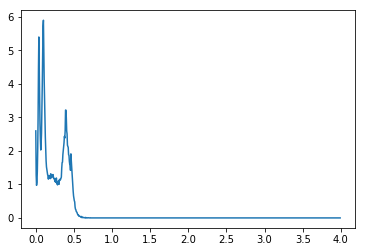

In [102]:
plt.plot(bin_diff_quad * np.array(xrange(len(bin_edges_quad)-1)), un_strat_quad_hists[0][4])

In [85]:
.002 * 2500

5.0

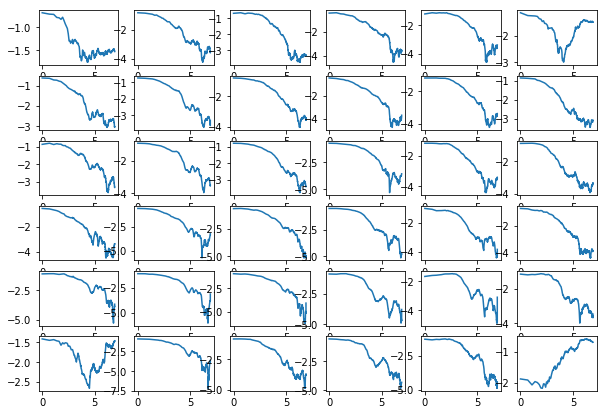

In [102]:
#Create the injection measure in just A_0, averaged to time i, for both stratified and un-stratified data
phi_sum_eig = np.zeros((J , n_iterations, 3))
phi_sum_un_strat= np.zeros((J, 3200, 3))
plt.figure(figsize = (10,7))
for s in xrange(6):
    for t in xrange(6):
        j = 6 * s + t

        nu_points = un_stratified_data[1][1][j]
        n_points = len(nu_points)
        for k in xrange(n_points):
            phi_sum_un_strat[j][0] += (1. / n_points) * np.array(test_function_values(coef_1, coef_2, coef_3, nu_points[k]))

        nu_points_eig = stratified_data[1][0][j]
        nu_probs_eig = stratified_data[1][1][j]
        n_points_eig = len(nu_points_eig)
        for k in xrange(n_points_eig):
            phi_sum_eig[j][0] += nu_probs_eig[k] * np.array(test_function_values(coef_1, coef_2, coef_3, nu_points_eig[k]))

        for i in xrange(3199):
            nu_points = un_stratified_data[i+2][1][j]
            n_points = len(nu_points)
            for k in xrange(n_points):
                phi_sum_un_strat[j][i+1] += (1. / n_points) * np.array(test_function_values(coef_1, coef_2, coef_3, nu_points[k]))
            phi_sum_un_strat[j][i+1] = phi_sum_un_strat[j][i] + phi_sum_un_strat[j][i+1]

        for i in xrange(999):
            nu_points_eig = stratified_data[2*(i+1)+1][0][j]
            nu_probs_eig = stratified_data[2*(i+1)+1][1][j]
            n_points_eig = len(nu_points_eig)
            for k in xrange(n_points_eig):
                phi_sum_eig[j][i+1] += nu_probs_eig[k] * np.array(test_function_values(coef_1, coef_2, coef_3, nu_points_eig[k]))
            phi_sum_eig[j][i+1] = phi_sum_eig[j][i] + phi_sum_eig[j][i+1]

        plt.subplot(6,6,j+1)
        plt.plot(np.log(xrange(1000)), [np.log(np.sum(abs(phi_sum_eig[j][i]/(i+1.) - phi_sum_un_strat[j][3199]/(3200.)))) for i in xrange(1000)], '-')
        #plt.plot(np.log(xrange(3199)), [np.log(np.sum(abs(phi_sum_un_strat[i]/(i+1.) - phi_sum_un_strat[i+1]/(i+2.)))) for i in xrange(3199)], '-')
plt.show()

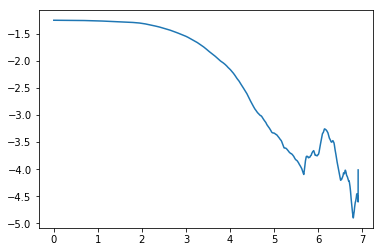

In [108]:
phi_avg_eig_tot = np.zeros((n_iterations, 3))
phi_avg_un_strat_tot = np.zeros(3)

for i in xrange(n_iterations):
    for j in xrange(J):
        phi_avg_eig_tot[i] += nu_weights_eig_avg[i][j] * np.array(phi_sum_eig[j][i] / (i+1.))

for j in xrange(J):
    phi_avg_un_strat_tot += weights_true[j] * np.array(phi_sum_un_strat[j][3199] / (3200.))

plt.plot(np.log(xrange(n_iterations)), [np.log(np.sum(abs(phi_avg_eig_tot[i] - phi_avg_un_strat_tot))) for i in xrange(n_iterations)], '-')
plt.show()

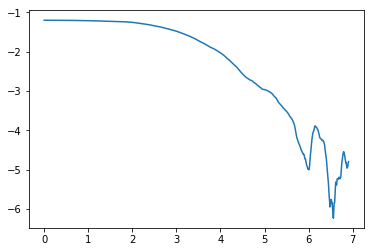

In [146]:
plt.plot(np.log(xrange(1000)), [np.log(np.sum(abs(phi_avg_eig_tot[i] - phi_avg_eig_tot[999]))) for i in xrange(1000)], '-')
plt.show()
#Try Comparing the one-simensional marginal of something with what you'd get if the distribution was just the exponential of the potential

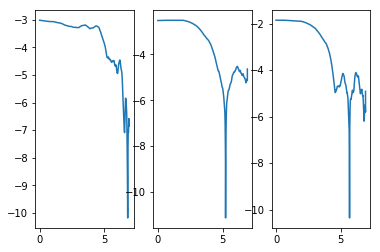

In [143]:
for s in xrange(3):
    plt.subplot(1,3,s+1)
    plt.plot(np.log(xrange(n_iterations)), [np.log(abs(phi_avg_eig_tot[i][s] - phi_avg_un_strat_tot[s])) for i in xrange(n_iterations)], '-')
plt.show()

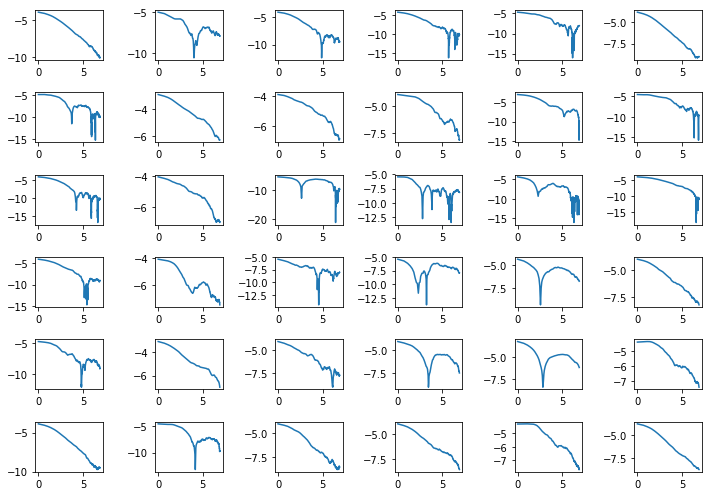

In [110]:
#Compute the un-averaged weights over the run
alpha = 0.5
nu_weights_eig_un_avg = np.zeros((n_iterations, J))
for i in xrange(n_iterations):
    nu_weights_eig_un_avg[i] = np.array(stratified_data[2*i+1][2])
    nu_weights_eig_un_avg[i] = nu_weights_eig_un_avg[i] / (np.sum(nu_weights_eig_un_avg[i]))

#Compute the Averaged Weights over the run
nu_weights_eig_avg = np.zeros((n_iterations, J))
nu_weights_eig_avg_exp = np.zeros((n_iterations, J))
nu_weights_eig_sum = np.zeros(J)
nu_weights_eig_avg_exp[0] = np.array(stratified_data[1][2])
for i in xrange(n_iterations-1):
    nu_weights_eig_sum += np.array(stratified_data[2*i+1][2])
    nu_weights_eig_avg[i] = nu_weights_eig_sum / (i + 1.)
    nu_weights_eig_avg_exp[i+1] = (1. - alpha) * nu_weights_eig_avg_exp[i] + alpha * np.array(stratified_data[2*(i+1)+1][2])
nu_weights_eig_sum += np.array(stratified_data[2*(n_iterations-1)+1][2])
nu_weights_eig_avg[n_iterations-1] = nu_weights_eig_sum / (1. * n_iterations)

plt.figure(figsize = (10,7))
for l in xrange(K):
    for k in xrange(K):
        j = l * K + k
    
        plt.subplot(K,K,j+1)
        #plt.figure(figsize = (10,10))
        #plt.ylim()
        #plt.plot(np.log(xrange(n_iterations)), [np.log(abs(nu_weights_eig_un_avg[i][j] - weights_true[j])) for i in xrange(n_iterations)])
        plt.plot(np.log(xrange(n_iterations)), [np.log(abs(weights_sum_eig[i][j]/(i+1.) - weights_true[j])) for i in xrange(n_iterations)])
        #plt.plot(np.log(xrange(n_iterations-1)), [np.log(abs(nu_weights_eig_avg[i+1][j] - nu_weights_eig_avg[i][j])) for i in xrange(n_iterations-1)])

plt.tight_layout()
#plt.show()

In [236]:
np.sqrt(np.var([np.sum(phi_sum_un_strat[0][i+1])-np.sum(phi_sum_un_strat[0][i]) for i in xrange(3199)])/3199.)

0.013850537244522992

3.0


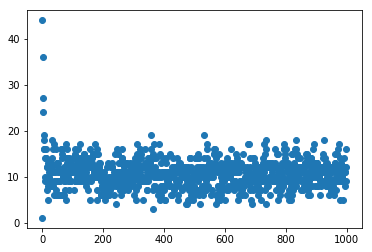

In [117]:
min_points = [np.amin(n_exits_in_eig[i]) for i in xrange(n_iterations)]
plt.plot(xrange(n_iterations), min_points, 'o')
print np.amin(np.array(min_points[1:]))

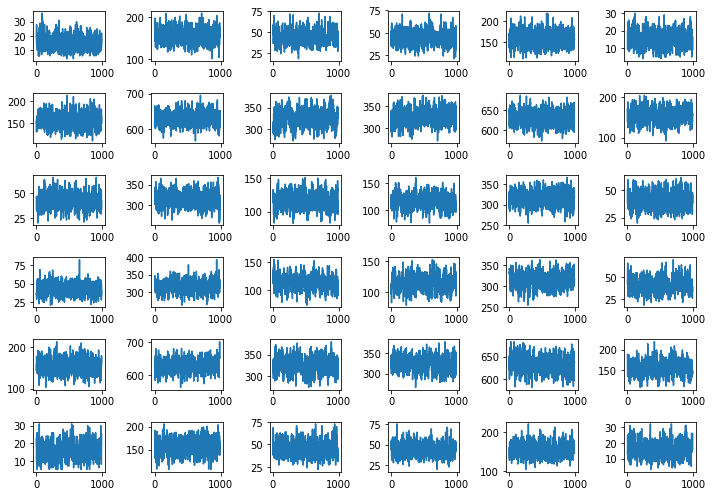

In [131]:
#Plot heat maps in some well converging strata and some"problem" strata
#Plot the number of exits into each stratum over time

n_exits_in_eig = np.zeros((n_iterations, J))
for i in xrange(n_iterations):
    nu_points = stratified_data[2 * i + 1][0]
    for j in xrange(J):
        n_exits_in_eig[i][j] = len(nu_points[j])

plt.figure(figsize = (10,7))
for l in xrange(K):
    for k in xrange(K):
        j = l * K + k
    
        plt.subplot(K,K,j+1)
        plt.plot(xrange(n_iterations-10), [n_exits_in_eig[i+10][j] for i in xrange(n_iterations-10)])
plt.tight_layout()
plt.show()

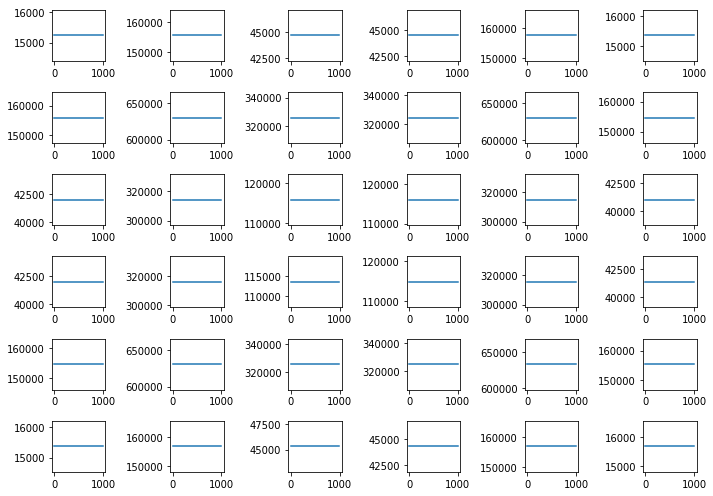

In [178]:
#Compute the variance of the test functions of the un-stratified sample, to see what scale of error it has. Make error bars. 
#Do the same for the stratified iterations. 
#Try making histograms of the test function values. 

plt.figure(figsize = (10,7))
for l in xrange(K):
    for k in xrange(K):
        j = l * K + k
    
        plt.subplot(K,K,j+1)
        plt.plot(xrange(n_iterations), [np.sum(n_exits_in_eig[:,j]) for i in xrange(n_iterations)])
        #plt.plot(xrange(n_iterations), [(np.sum(n_exits_in_eig[:,j]) - n_points_un_strat_one_stratum[j])/n_points_un_strat_one_stratum[j] for i in xrange(n_iterations)])
plt.tight_layout()
plt.show()

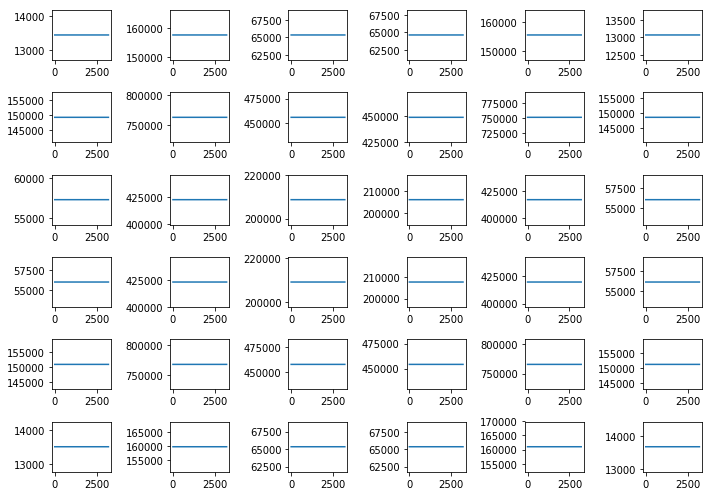

In [134]:
plt.figure(figsize = (10,7))
for l in xrange(K):
    for k in xrange(K):
        j = l * K + k
    
        plt.subplot(K,K,j+1)
        plt.plot(xrange(n_hist_tot), [n_points_un_strat_one_stratum[j] for i in xrange(n_hist_tot)])
plt.tight_layout()
plt.show()

In [90]:
np.array([1,4])**2

array([ 1, 16])